In this notebook, we:
- Tune a Gabor filter to enhance cracks
- Apply this filter to all images
- Concatenate the filtered images with the unfiltered images
- Train a convolutional neural network against the result

### Import the libraries

In [1]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Deactive warnings about building from source

from scipy.misc import imread, imresize
from datetime import datetime
from os.path import exists
from shutil import rmtree
from os import makedirs
import tensorflow as tf
from glob import glob
import numpy as np

from models import two_layer_convnet
from pymvtest import classification

from skimage.filters import sobel_h, sobel_v
from skimage.filters import gabor_kernel
from scipy.signal import convolve

import matplotlib.pyplot as plt
%matplotlib inline

### Import the data

In [2]:
print('Importing data...')

# Whiten on import
images = np.array([np.expand_dims(imread(fp), axis = -1)
                  for fp in glob('./data/resized-images/*.png')])
masks  = np.array([imread(fp)/255 for fp in glob('./data/masked-images/*.png')])
print('Data imported.')

Importing data...
Data imported.


### Define the filter

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  return out.astype(volume.dtype)


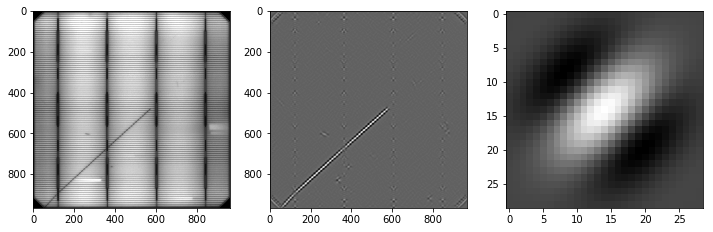

In [3]:
def _filter(image):
    if len(image.shape) == 3: image = image.squeeze()
    K = gabor_kernel(frequency = 0.05, theta = np.pi/4, bandwidth = 2)
    image = sobel_h(image)
    image = sobel_v(image)
    re_l = np.real(convolve(image, K, mode = 'same'))
    re_r = np.real(convolve(image, np.flip(K, axis=0), mode = 'same'))
    image   = re_l - re_r
    return np.expand_dims(image, axis = -1)

K = gabor_kernel(frequency = 0.05, theta = np.pi/4, bandwidth = 2)

f, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(images[14, :, :, 0], cmap = 'gray')
axs[1].imshow(_filter(images[14, :, :, 0])[:, :, 0], cmap = 'gray')
axs[2].imshow(np.real(K), cmap = 'gray');

### Apply the filter to all of the images

In [4]:
print('Filtering images...')
images = np.array([np.concatenate([img, _filter(img)], axis = 2) for img in images])
print('Images filtered and stacked.')

Filtering images...


/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  return out.astype(volume.dtype)


Images filtered and stacked.


### Define the master dictionary

In [5]:
TF = {
      'batch_size':32,
      'graph':None,
      'image_size':200,
      'patch_size':20,
      'input_channels':2,
      'learning_rate':0.001,
      'n_classes':2,
      'output_channels':[16, 8, 32],
      'filter_size':[3, 5],
      'seed':3,
      'split_fraction':0.7,
      'summary_train':[],
      'training_steps':20001,
      'test_id':'002_Gabor_filtered',
}
print('Training for {} iterations.'.format(TF['training_steps']))
print('{} units per batch.'.format(TF['batch_size']))

Training for 20001 iterations.
32 units per batch.


### Prepare the data for training

In [6]:
print('Whitening and resizing images...')
# Whiten the images
eps = 1e-6
white_images = (images - np.mean(images, axis = 0))/(np.std(images, axis = 0)+eps)

# Resize the images
res_images, res_masks = classification.resize(white_images, masks, TF['image_size'])
print('Images whitened and resized.')

Whitening and resizing images...
Images whitened and resized.


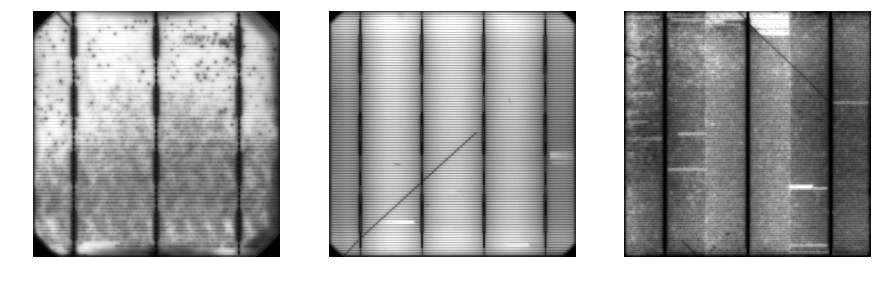

In [7]:
# Extract three images for testing, use the test for training/validation
query_ix      = np.array([(i == 4 or i == 14 or i == 38) for i in range(0, images.shape[0])])
train_ix      = np.logical_not(query_ix)
query_images  = images[query_ix, :, :, :]
query_masks   = masks[query_ix, :, :]
images        = images[train_ix, :, :, :]
masks         = masks[train_ix, :, :]

f, axs = plt.subplots(1, 3, figsize = (15, 5))
for i, ax in enumerate(axs):
    ax.imshow(query_images[i, :, :, 0], cmap = 'gray')
    ax.axis('off');

### Train a network against these images

In [8]:
# Get the graph
TF     = two_layer_convnet.model(TF)

# Fit the model
tester = classification.Tester(res_images, res_masks, TF)
tester.fit_model()

Training dataset dimensions: (41, 200, 200, 2)
Validation dataset dimensions: (11, 200, 200, 2)

Fitting model...
(Step   0  ) Validation accuracy:    0.51

(Step  100 ) Minibatch accuracy:     0.66
(Step  100 ) Minibatch loss:       0.6437
(Step  100 ) Validation accuracy:    0.70

(Step  200 ) Minibatch accuracy:     0.78
(Step  200 ) Minibatch loss:       0.4607
(Step  200 ) Validation accuracy:    0.80

(Step  300 ) Minibatch accuracy:     0.94
(Step  300 ) Minibatch loss:       0.2346
(Step  300 ) Validation accuracy:    0.85

(Step  400 ) Minibatch accuracy:     0.88
(Step  400 ) Minibatch loss:       0.2943
(Step  400 ) Validation accuracy:    0.93

(Step  500 ) Minibatch accuracy:     1.00
(Step  500 ) Minibatch loss:       0.0456
(Step  500 ) Validation accuracy:    0.91

(Step  600 ) Minibatch accuracy:     0.91
(Step  600 ) Minibatch loss:       0.2265
(Step  600 ) Validation accuracy:    0.90

(Step  700 ) Minibatch accuracy:     0.91
(Step  700 ) Minibatch loss:       0.13

(Step 6500 ) Minibatch accuracy:     1.00
(Step 6500 ) Minibatch loss:       0.0232
(Step 6500 ) Validation accuracy:    0.95

(Step 6600 ) Minibatch accuracy:     0.97
(Step 6600 ) Minibatch loss:       0.0494
(Step 6600 ) Validation accuracy:    0.95

(Step 6700 ) Minibatch accuracy:     1.00
(Step 6700 ) Minibatch loss:       0.0380
(Step 6700 ) Validation accuracy:    0.94

(Step 6800 ) Minibatch accuracy:     0.97
(Step 6800 ) Minibatch loss:       0.0370
(Step 6800 ) Validation accuracy:    0.96

(Step 6900 ) Minibatch accuracy:     0.97
(Step 6900 ) Minibatch loss:       0.1513
(Step 6900 ) Validation accuracy:    0.95

(Step 7000 ) Minibatch accuracy:     0.94
(Step 7000 ) Minibatch loss:       0.0829
(Step 7000 ) Validation accuracy:    0.95

(Step 7100 ) Minibatch accuracy:     0.97
(Step 7100 ) Minibatch loss:       0.0505
(Step 7100 ) Validation accuracy:    0.93

(Step 7200 ) Minibatch accuracy:     1.00
(Step 7200 ) Minibatch loss:       0.0264
(Step 7200 ) Validation acc

(Step 13000) Minibatch accuracy:     1.00
(Step 13000) Minibatch loss:       0.0111
(Step 13000) Validation accuracy:    0.94

(Step 13100) Minibatch accuracy:     0.97
(Step 13100) Minibatch loss:       0.0662
(Step 13100) Validation accuracy:    0.96

(Step 13200) Minibatch accuracy:     0.97
(Step 13200) Minibatch loss:       0.1788
(Step 13200) Validation accuracy:    0.93

(Step 13300) Minibatch accuracy:     0.97
(Step 13300) Minibatch loss:       0.1046
(Step 13300) Validation accuracy:    0.95

(Step 13400) Minibatch accuracy:     0.97
(Step 13400) Minibatch loss:       0.0499
(Step 13400) Validation accuracy:    0.95

(Step 13500) Minibatch accuracy:     1.00
(Step 13500) Minibatch loss:       0.0347
(Step 13500) Validation accuracy:    0.95

(Step 13600) Minibatch accuracy:     1.00
(Step 13600) Minibatch loss:       0.0258
(Step 13600) Validation accuracy:    0.95

(Step 13700) Minibatch accuracy:     0.97
(Step 13700) Minibatch loss:       0.1181
(Step 13700) Validation acc

(Step 19500) Minibatch accuracy:     1.00
(Step 19500) Minibatch loss:       0.0201
(Step 19500) Validation accuracy:    0.95

(Step 19600) Minibatch accuracy:     0.97
(Step 19600) Minibatch loss:       0.0827
(Step 19600) Validation accuracy:    0.95

(Step 19700) Minibatch accuracy:     1.00
(Step 19700) Minibatch loss:       0.0191
(Step 19700) Validation accuracy:    0.95

(Step 19800) Minibatch accuracy:     0.94
(Step 19800) Minibatch loss:       0.2408
(Step 19800) Validation accuracy:    0.94

(Step 19900) Minibatch accuracy:     0.97
(Step 19900) Minibatch loss:       0.0965
(Step 19900) Validation accuracy:    0.95

(Step 20000) Minibatch accuracy:     0.94
(Step 20000) Minibatch loss:       0.2021
(Step 20000) Validation accuracy:    0.95



In [9]:
# Query the model
res_query_images, res_query_masks = classification.resize(query_images, query_masks, TF['image_size'])
predictions, query_masks = tester.query_model(res_query_images, res_query_masks)

INFO:tensorflow:Restoring parameters from ./checkpoints/pending.ckpt


ValueError: cannot reshape array of size 240000 into shape (3,200,200)

In [17]:
with tf.Session(graph = tester.tf_graph) as session:

    tester.tf_saver.restore(session, './checkpoints/'+tester.test_id+'.ckpt')

    predictions = np.zeros_like(res_query_masks, dtype = np.float32).flatten()

    for j, ix in enumerate(np.array(np.nonzero(np.ones_like(res_query_masks))).T):
        ix               = np.array([ix])
        q_patch, q_label = classification.get_patches(res_query_images, res_query_masks, ix, tester.patch_size)
        fd               = {tester.tf_data:q_patch, tester.tf_labels:q_label}
        predictions[j]   = session.run(tester.tf_predictions, feed_dict = fd)[0, 1]

INFO:tensorflow:Restoring parameters from ./checkpoints/pending.ckpt


In [19]:
predictions = predictions.reshape(res_query_masks.shape)

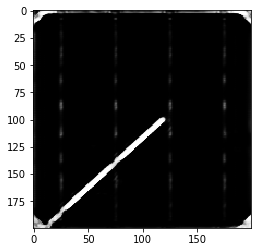

In [26]:
plt.imshow(predictions[1,:,:], cmap = 'gray')